In [1]:
import numpy as np
from scipy import signal
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import pandas as pd

from filt_plot_funcs import *

fs = 200


In [2]:
def normalize(xn):
    return (xn - np.min(xn)) / (np.max(xn) - np.min(xn))

def quantizeTo12Bit(xn):
    yn = (xn * (1 << 11)) // 1
    yn /= 1 << 11
    return yn

def convertToFixedPoint_Q31(xn):
    xn /= np.max(np.abs(xn))
    xn = ( xn * (1 << 31) ) // 1
    return np.array(xn, dtype=int)


## DAQ

### Low Pass Filter

In [3]:
sos = signal.iirfilter(N = 4, Wn = 40, btype="lowpass", ftype='butter', fs=fs, output='sos')


### IIR Notch Filter

abs(p) = [0.97787352 0.97787352 0.97818754 0.97818754]


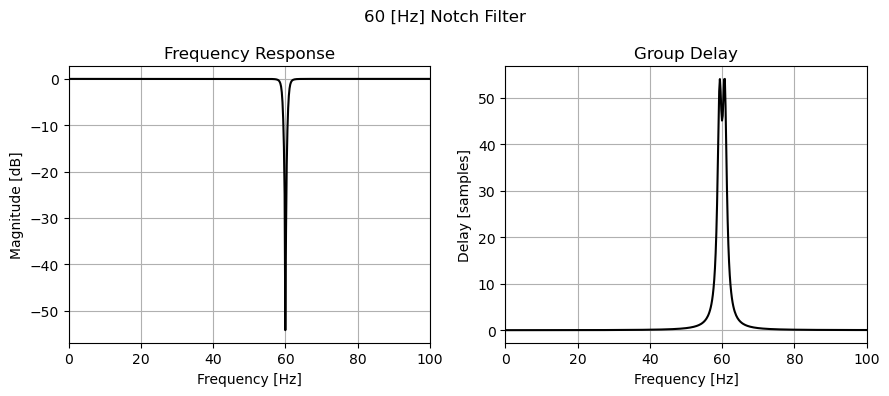

<Figure size 640x480 with 0 Axes>

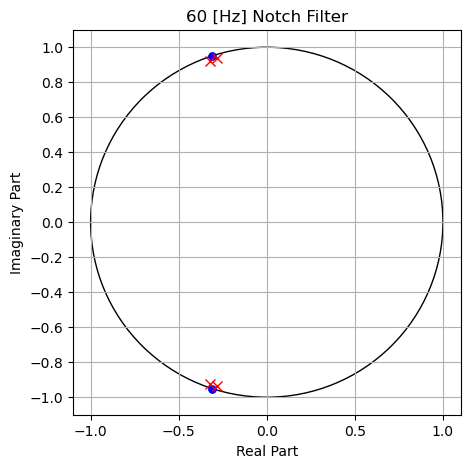

In [4]:
sos = signal.iirfilter(N=2, Wn=[59, 61], btype='bandstop', output='sos', fs=fs)

z, p, k = signal.sos2zpk(sos)
print(f"abs(p) = {np.abs(p)}")

b, a = signal.sos2tf(sos)
plot_domain_f(b, a, fs=fs, in_dB=True, filt_name="60 [Hz] Notch Filter")
plot_pole_zero(b, a, filt_name="60 [Hz] Notch Filter")

In [5]:
print("{", end='')
for section in sos:
    for idx, num in enumerate(section):
        if idx != 3:
            print(f"{num}, ", end='\n')
            
print("};")


{0.9565432255568765, 
0.5914680788951381, 
0.9565432255568764, 
0.5631667954285263, 
0.9562366248653332, 
1.0, 
0.618339101770126, 
0.9999999999999999, 
0.6460562453305682, 
0.9568508578410597, 
};


### DAQ Filter Test

In [6]:
data = pd.read_csv("../../data/101.csv")
data.describe()

,Unnamed: 0,0
count,361111.000000,361111.000000
mean,180555.000000,-0.284222
std,104243.910866,0.261132
min,0.000000,-3.165415
25%,90277.500000,-0.401950
50%,180555.000000,-0.329274
75%,270832.500000,-0.235140
max,361110.000000,2.418641


In [7]:
# Convert to fixed-point
xn = np.array(data.iloc[:,1])

N = len(xn)
n = np.linspace(0, N, N)

# Generate 60 [Hz] noise
t = n / fs
noise = np.sin(2 * np.pi * 60 * t)

# Filter
yn = signal.lfilter(b, a, xn + noise)


In [8]:
pd.DataFrame(xn).describe()

,0
count,361111.000000
mean,-0.284222
std,0.261132
min,-3.165415
25%,-0.401950
50%,-0.329274
75%,-0.235140
max,2.418641


In [9]:
Xf = rfft(xn, N)
X1f = rfft(xn + noise, N)
Yf = rfft(yn, N)

f = rfftfreq(N, 1/fs)

/Users/bryanmcelvy/opt/anaconda3/envs/ecg_hrm_py/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/bryanmcelvy/opt/anaconda3/envs/ecg_hrm_py/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


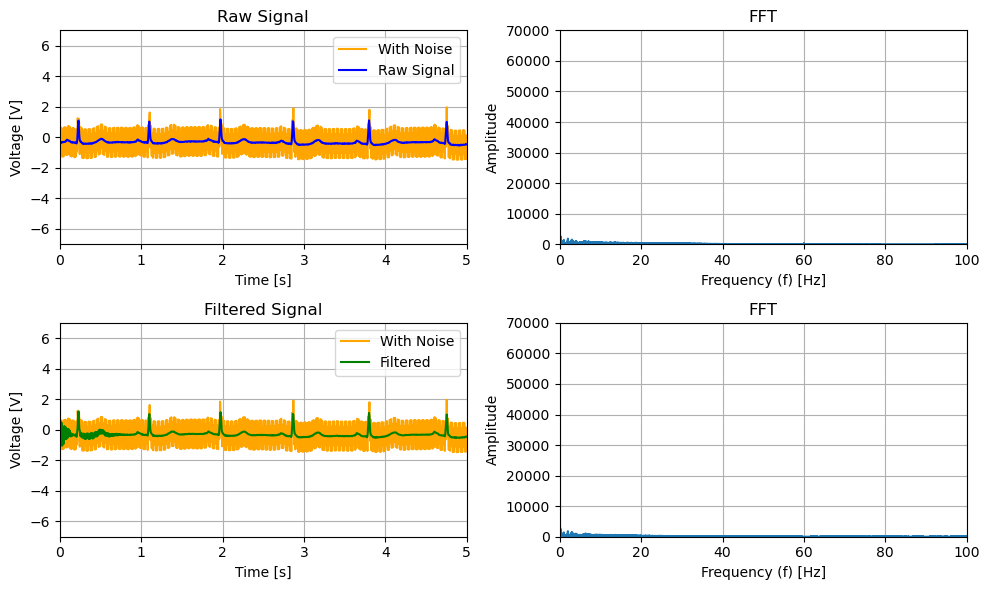

In [10]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=[10, 6])

start = 0 * fs
duration = 5 * fs
end = start + duration

plt.sca(axs[0][0])
plt.title("Raw Signal")
plt.plot(n[start:end]/fs, (xn + noise)[start:end], color='orange', label="With Noise")
plt.plot(n[start:end]/fs, xn[start:end], color='blue', label="Raw Signal")

plt.sca(axs[0][1])
plt.title("FFT")
plt.plot(f, Xf)

plt.sca(axs[1][0])
plt.title("Filtered Signal")
plt.plot(n[start:end]/fs, (xn + noise)[start:end], color='orange', label="With Noise")
plt.plot(n[start:end]/fs, yn[start:end], color='green', label="Filtered")

plt.sca(axs[1][1])
plt.title("FFT")
plt.plot(f, Yf)

for row in axs:
    for idx, ax in enumerate(row):
        ax.grid(True)
        if idx == 0: 
            ax.set_xlim(np.array([start, end])/fs)
            ax.set_ylim(np.array([-1, 1]) * 7)
            ax.set_xlabel("Time [s]")
            ax.set_ylabel("Voltage [V]")
            ax.legend()
        else: 
            ax.set_xlim([0, 100])
            ax.set_ylim([0, 70000])
            ax.set_xlabel("Frequency (f) [Hz]")
            ax.set_ylabel("Amplitude")


## QRS

### QRS LPF

In [ ]:
b, a = signal.iirfilter(N=2, Wn=20, btype='lowpass', ftype='butter', fs=fs)
b = np.single(b)
a = np.single(a)

print(f"b = {b}\na = {a}")


In [ ]:
sos = signal.tf2sos(b, a).astype(dtype=np.float16)

print(f"Unformatted:\n{sos}")
print(f"\nFormatted:", end='')
for section_num in range(np.shape(sos)[0]):
    print("\n")
    for coeff in range(np.shape(sos)[1]):
        print(sos[section_num][coeff], end=", ")

In [ ]:
plot_domain_t(b, a)

_, [ax1, ax2] = plt.subplots(1, 2, figsize=[9, 4], tight_layout=True)

plot_domain_f(b, a, fs=fs, ax1=ax1, ax2=ax2)

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.axvline(x=30, linestyle='dashed', color='r', label="Cutoff Frequency")
    plt.legend()
    
plot_pole_zero(b, a)

### QRS HPF

In [ ]:
b, a = signal.iirfilter(N=2, Wn=12, btype='highpass', ftype='butter', fs=fs)
b = np.single(b)
a = np.single(a)

print(f"b = {b}\na = {a}")


In [ ]:
sos = signal.tf2sos(b, a).astype(dtype=np.float16)

print(f"Unformatted:\n{sos}")
print(f"\nFormatted:", end='')
for section_num in range(np.shape(sos)[0]):
    print("\n")
    for coeff in range(np.shape(sos)[1]):
        print(sos[section_num][coeff], end=", ")

In [ ]:
plot_domain_t(b, a)

_, [ax1, ax2] = plt.subplots(1, 2, figsize=[9, 4], tight_layout=True)

plot_domain_f(b, a, fs=fs, ax1=ax1, ax2=ax2)

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.axvline(x=30, linestyle='dashed', color='r', label="Cutoff Frequency")
    plt.legend()
    
plot_pole_zero(b, a)

### QRS Derivative Filter

In [ ]:
b = np.array( [1, 2, 0, -2, -1] ) / 8
a = np.zeros(np.shape(b))
a[0] = 1

b = np.single(b)
a = np.single(a)

print(f"b = {b}\na = {a}")

In [ ]:
plot_domain_t(b, a)

_, [ax1, ax2] = plt.subplots(1, 2, figsize=[9, 4], tight_layout=True)

plot_domain_f(b, a, fs=fs, ax1=ax1, ax2=ax2)

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.axvline(x=30, linestyle='dashed', color='r', label="Cutoff Frequency")
    plt.legend()
    
plot_pole_zero(b, a)

### QRS MA Filter

In [ ]:
M = 15
b = np.ones(M) / M
a = np.zeros(np.shape(b))
a[0] = 1

b = np.single(b)
a = np.single(a)

print(f"b = {b}\na = {a}")

In [ ]:
plot_domain_t(b, a)

_, [ax1, ax2] = plt.subplots(1, 2, figsize=[9, 4], tight_layout=True)

plot_domain_f(b, a, fs=fs, ax1=ax1, ax2=ax2)

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.axvline(x=30, linestyle='dashed', color='r', label="Cutoff Frequency")
    plt.legend()
    
plot_pole_zero(b, a)